# Cohen Yuval
### ID : 208570184

# Map Of Content
1. Data Scraping
2. Dataset generation using NRE or any other algorithm , deep learning not allowed
3. 2-5 subject tags for each verdict using itf-idf or any other algorithm
4. 2-5 subject tags for each verdict using Word2Vec (same as 3)
-  Compare (3) and (4)
5. Dataset Statistics
    - In Certain TimeFrame:
    - a. Number of verdict of each judge
    - b. Number of verdicts each judge gave in the top 10 popular subject tags
6. Use RNN to perform NER recognision for dataset generation(2) 
7. - Compare 2 and 6
8. Use RNN to peform sentiment analysis on each verdict,  add sentiment Column for dataset (POSITIVE NETURAL NEGETIVE)
9. Dataset Statistics with extra stats:
    - number of verdicts each judge gave for every sentiment type
    - In Certain TimeFrame: num of verdicts all judges gave for every sentiment type  
10. 2-5 subject tags for each verdict using AUTOENCODER  
- Compare (3), (4) , (10)

# Resources

- alefbert : https://github.com/OnlpLab/AlephBERT

# IMPORTS

In [2]:
import os
import datasets
import typing
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

import random
from gensim import utils
import datetime
import matplotlib.pyplot as plt
import regex as re
import transformers
import string

import numpy as np
from pprint import pprint
from tqdm import tqdm,tqdm_notebook
from collections import Counter
import json
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec,LineSentence
from gensim.corpora import WikiCorpus
from multiprocessing import cpu_count
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModel,pipeline

import nltk
from nltk.corpus import stopwords
from nltk.stem import *
from nltk.corpus import *
from nltk.tokenize import word_tokenize

import fasttext.util
import fasttext
import time
import multiprocessing
import spacy
import word2vec
import tensorflow
from torch.utils.data import Dataset,DataLoader
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from numpy.random import seed
from gensim.corpora import WikiCorpus
import math
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datasets import load_dataset
from collections import Counter
from conlleval import evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed(1)
tensorflow.random.set_seed(2)
pd.set_option('display.max_columns', None)

# DOWNLOADS

In [3]:
def get_dirs():
    dirs = []
    batches = []
    for _ ,dirname, files in os.walk("./../data"):
        dirs.append(dirname)
        f = [file for file in files if file.endswith(".csv")]
        if len(f) == 0:
            continue
        f = f[0]
        batches.append(f)
    queries = dirs[0]
    return queries

def get_data_path(base_dir,query):
    path = os.path.join(base_dir,query,"csv",f"{query}.csv")
    return path

def data_gen():
    base_dir = "./../data"
    queries = get_dirs()
    for query in queries:
        path = get_data_path(base_dir,query)
        batch = pd.read_csv(path)
        yield batch

        
queries = get_dirs()
    

In [4]:
nltk.download("all",download_dir='./data/nltk')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to ./data/nltk...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to ./data/nltk...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     ./data/nltk...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     ./data/nltk...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to ./data/nltk...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to ./data/nltk...
[nltk_data]    |   Package bcp47 is already up-to-date!
[nltk_data]    | Downloading package biocr

True

# CONSTANTS

In [5]:
batch_directory = "./data/supreme"
file_prefix = "verdict_batch"
file_type = "csv"

# CONFIG

In [6]:
BATCH_SIZE = 1000

# UTILS

### FILES UTILS

In [7]:
def get_filename(idx):
    filename =  f"{file_prefix}_{idx}.{file_type}"
    return filename

In [8]:
def get_verdicts(df:pd.DataFrame):
    return df[df['meta_verdict_ty'] == "פסק-דין"]

In [9]:
def get_filesnames():
    return [file for file in os.listdir(batch_directory) if file.endswith(f".{file_type}")]

In [10]:
def read_hebrew_words_file(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        hebrew_words = [line.strip() for line in file]
    return hebrew_words

In [11]:
def download_verdicts_data():
    if len(get_filesnames()) > 0:
        print(True)
        return
    data = datasets.load_dataset('LevMuchnik/SupremeCourtOfIsrael')
    train = data['train']
    num_batches = len(train) / BATCH_SIZE
    train_loader = train.to_pandas(batch_size=BATCH_SIZE,batched=True)
    j = 0
    for i , data in tqdm(enumerate(train_loader),total=num_batches):
        verdict_df = get_verdicts(data)
        if not verdict_df.empty:
            file_name = get_filename(j)
            verdict_df.to_csv(f"{batch_directory}/{file_name}", index=False)
            j += 1

In [12]:
def update_file(i,batch,csv_files):
    file_path = os.path.join(batch_directory, csv_files[i])
    batch.to_csv(file_path, index=False)

### WORDS UTILS

In [13]:
def contains_hebrew_letter(text:str):
    pattern = re.compile(r'[\u0590-\u05FF]+')
    return bool(re.search(pattern, text))

def remove_punctuation_except(text:str, exceptions:list[str]=[]):
    punctuation = string.punctuation
    for exception in exceptions:
        punctuation = punctuation.replace(exception, '')
    translator = str.maketrans('', '', punctuation)
    return text.translate(translator)

def remove_extra_spaces(string):
    modified_string = re.sub(r'\n', ' ', string)
    modified_string = re.sub(r'\s+', ' ', modified_string)
    return modified_string

def remove_extra_spaces_without_lines(string):
    modified_string = re.sub(r'\n', '@', string)
    modified_string = re.sub(r'\s+', ' ', modified_string)
    modified_string = re.sub(r'@', '\n', modified_string)
    return modified_string

def is_hebrew_stop_word(word:str,hebrew_stopwords:list[str]):
    return word in hebrew_stopwords

def valid_non_stop_hebrew_word(text:str,hebrew_stopwords:list[str]):
    if len(text) < 2:
        return False
    if text.isdigit():
        return False
    if not contains_hebrew_letter(text):
        return False
    if len(text) == 2 and "'" in text:
        return False
    if is_hebrew_stop_word(text,hebrew_stopwords):
        return False
    return True

def word_without_prefix(word,prefixes:list[str],word_list:list[str]):
    if word in word_list:
        return word
    for prefix in prefixes:
        prefix_len = len(prefix)
        if len(word) > prefix_len:
            if word[:prefix_len] == prefix:
                no_prefix_word = word[prefix_len:]
                if no_prefix_word in word_list:
                    return no_prefix_word
    return word

def valid_hebrew_word(text:str):
    if len(text) < 2:
        return False
    if text.isdigit():
        return False
    if not contains_hebrew_letter(text):
        return False
    if len(text) == 2 and "'" in text:
        return False
    return True


def str_list_to_list(string_list:str):
    lst = string_list.strip("[]")
    lst = lst.replace("'", "")
    lst = lst.split(",")
    return [item.strip() for item in lst]


def super_string_list_to_list(row_item:str):
    item =  row_item.strip("[]")
    if len(item) == 0:
        return []
    
    item = item.replace(","," ")
    pattern1 = r"(?<=\s)'|'(?=\s)"
    pattern2 = r'(?<=\s)"|"(?=\s)'
    item = re.sub(pattern1, ",", item)
    item = re.sub(pattern2, ",", item)
    if '"' in item[0]:
        item = item[1:]
    if "'" in item[0]:
        item = item[1:]        
    l = len(item)
    if '"' in item[l - 1]:
        item = item[:l - 1]
    l = len(item)
    if "'" in item[l - 1]:
        item = item[:l-1]            
    item = remove_extra_spaces(item)
    lst = item.split(",")
    lst = [l.strip() for l in lst if len(l.strip()) > 0]
    return lst

def reverse_words_order(text:str):
    words = text.split()  
    reversed_words = list(reversed(words))
    reversed_text = ' '.join(reversed_words)
    return reversed_text


In [14]:
def sort_word_dict(d:dict):
    sorted_dict = dict(sorted(d.items() ,key=lambda item:item[1],reverse=True))
    return sorted_dict

In [15]:
def remove_keys_from_dict(d:dict,keys:list[str],prefix:int=0):
    for prefix in range(prefix):
        for rm_word in keys:
            if rm_word[prefix:] in d.keys():
                del d[rm_word[prefix:]]
    
            
def remove_file_words_from_verdict(idf_dict:dict,path:str,prefix:int=0):
    words = read_hebrew_words_file(path)
    remove_keys_from_dict(idf_dict,words,prefix)
    del words

In [16]:
def get_normalized_bag_of_words(text:str,hebrew_stopwords:list[str],prefixes:list[str],word_list:list[str]):
    t = remove_extra_spaces(text).strip()
    t = remove_punctuation_except(t,['"'])
    words = t.split(" ")
    bag = Counter(words)
    bag = {word_without_prefix(key,prefixes,word_list):value for key,value in bag.items() if valid_non_stop_hebrew_word(key,hebrew_stopwords)}
    sorted_bag = dict(sorted(bag.items() ,key=lambda item:item[1],reverse=True))
    return sorted_bag

def get_bag_of_words(text:str):
    t = remove_extra_spaces(text).strip()
    t = remove_punctuation_except(t,['"','-',"'"])
    words = t.split(" ")
    bag = Counter(words)
    bag = {key:value for key,value in bag.items() if valid_hebrew_word(key)}
    sorted_bag = dict(sorted(bag.items() ,key=lambda item:item[1],reverse=True))
    return sorted_bag

def get_unordered_bag_of_words(text:str):
    t = remove_extra_spaces(text).strip()
    t = remove_punctuation_except(t,['"','-',"'"])
    words = t.split(" ")
    words = [word.strip() for word in words if len(word.strip()) > 0]
    return words

def get_raw_bag_of_words(text:str):
    t = remove_extra_spaces(text).strip()
    words = t.split(" ")
    words = [word.strip() for word in words if len(word.strip()) > 0]
    return words

In [17]:
def read_hebrew_stop_words():
    itdk_stopwords = stopwords.words("hebrew")
    total_stopwords = []
    txt_stopwords = []
    with open("../heb_stopwords.txt") as f:
        for line in f:
            txt_stopwords.append(f.readline())
    txt_stopwords = txt_stopwords[:len(txt_stopwords)- 1]
    txt_stopwords = [word.split("\n")[0].strip() for word in txt_stopwords]
    total_stopwords.extend(txt_stopwords)
    total_stopwords.extend(itdk_stopwords)
    total_stopwords = list(set(total_stopwords))
    return total_stopwords


In [18]:
nouns_path = "../txt_files/hebrew_wordlists-main/nouns.txt"
adjectives_path = "../txt_files/hebrew_wordlists-main/adjectives.txt"
places_path = "../txt_files/hebrew_wordlists-main/israeli_place_names.txt"
prefixes_path = "../txt_files/hebrew_wordlists-main/prefixes.txt"
preposition_path = "../txt_files/hebrew_wordlists-main/prepositions.txt"
append_fatverbs_path = "../txt_files/hebrew_wordlists-main/all_append_fatverb.txt"
before_append_fatverbs_path = "../txt_files/hebrew_wordlists-main/all_append_fatverb_after_append_some_prefixes.txt"
after_append_fatverbs_path = "../txt_files/hebrew_wordlists-main/all_append_fatverb_before_append_some_prefixes.txt"
no_fatverbs_path = "../txt_files/hebrew_wordlists-main/all_no_fatverb.txt"
append_no_fatverbs_prefixes_path = "../txt_files/hebrew_wordlists-main/all_no_fatverb_append_some_prefixes.txt"
only_no_fatverbs_prefixes_path = "../txt_files/hebrew_wordlists-main/all_no_fatverb_only_some_prefixes.txt"
with_no_fatverbs_prefixes_path = "../txt_files/hebrew_wordlists-main/all_no_fatverb_with_some_prefixes.txt"
only_fatverbs_path = "../txt_files/hebrew_wordlists-main/all_only_fatverb.txt"
append_with_fatverbs_prefixes_path = "../txt_files/hebrew_wordlists-main/all_with_fatverb_append_some_prefixes.txt"
only_with_fatverbs_prefixes_path = "../txt_files/hebrew_wordlists-main/all_with_fatverb_only_some_prefixes.txt"
with_with_fatverbs_prefixes_path = "../txt_files/hebrew_wordlists-main/all_with_fatverb_with_some_prefixes.txt"
with_fatverbs_path = "../txt_files/hebrew_wordlists-main/all_with_fatverb.txt"
gerunds_path = "../txt_files/hebrew_wordlists-main/gerunds.txt"


exel_hebrew_stopwords_df = pd.read_excel("../stopwords.xlsx") 
nltk_txt_hebrew_stopwords_df = read_hebrew_stop_words()


1. Data Scraping

2. Dataset generation using NRE or any other algorithm , deep learning not allowed

In [19]:
download_verdicts_data()

True


In [20]:
csv_files = get_filesnames()
def batch_generator():
    for csv_file in csv_files:
        df = pd.read_csv(os.path.join(batch_directory, csv_file))
        yield df

## 3. 2-5 subject tags for each verdict using itf-idf or any other algorithm

3.1 it is very complex for hebrew to implememnt:
- Lemmatization algorithm 
- Stemming algorithm   

3.2 i could not find a lemmatization or stemming algorithm for hebrew

In [21]:
idf_dict_filename = "idf_dict"
ROW_TF_IDF = "tf_idf"
ROW_WORD2VEC = "word2vec"
ROW_WORD2VEC_SIMILARITY_WORDS= "word2vec_similarity_words"
ROW_AUTOENCODER = "autoencoder"
NUM_TAGS = 5

In [22]:
def compute_idf(idf_dict:dict, bag_dict:dict):
    words = list(bag_dict.keys())
    for word in words:
        if not idf_dict.get(word):
            idf_dict.update({word:0})
    for word,count in bag_dict.items():
        idf_dict[word] += count  

def normalized_idf(idf_dict:dict):
    total = 0
    for word,count in idf_dict.items():
        total += count
    for word,count in idf_dict.items():
        idf_dict[word] = count / total


def compute_tf(bag_dict:dict): # self freqs = term freq =  tf
    total_num_words = 0
    for word,count in bag_dict.items():
        total_num_words += count
    tf_bag = bag_dict.copy()
    for word,count in tf_bag.items():
        tf_bag[word] = float(count) / float(total_num_words)
    return tf_bag

def compute_tf_idf(bag_dict:dict,idf_dict:dict):
    tf_idf_dict = {}
    tf_bag_dict = compute_tf(bag_dict)
    for word,count in tf_bag_dict.items():
        if word in idf_dict.keys():
            tf_idf_dict[word] = count * idf_dict[word]
    return tf_idf_dict   

def get_idf_dict(generator,files_names,override=True):
    if override is False:
        if os.path.exists("./idf_dict.json"):
            with open('./idf_dict.json') as json_file:
                data = json.load(json_file)
            return data
    idf_dict = {}
    for i,batch in tqdm(enumerate(generator()),total=len(files_names)):
        batch = batch[batch['text'].notna()]
        for index,row in batch.iterrows():
            text = row['text']
            bag_dict = get_bag_of_words(text)
            compute_idf(idf_dict,bag_dict)
    return sort_word_dict(idf_dict)



def save_dict(d:dict,name:str):
    json_data = json.dumps(d,ensure_ascii=False,indent=4)
    with open(f'./{name}.json', "w",encoding="utf-8") as json_file:
        json_file.write(json_data)


def tf_idf_df(idf_dict):
    for i,batch in tqdm(enumerate(batch_generator()),total=len(csv_files)):
        batch[f'{ROW_TF_IDF}_tags'] = ''
        batch[ROW_TF_IDF] = ''
        for index,row in batch.iterrows():
            text = row['text']
            bag_dict = get_bag_of_words(text)
            d = compute_tf_idf(bag_dict,idf_dict)
            d = sort_word_dict(d)
            batch.at[index,ROW_TF_IDF] = json.dumps(d)
            tags = [word for word, count in d.items()]
            t_tags = tags[:NUM_TAGS]
            batch.at[index,f'{ROW_TF_IDF}_tags'] = t_tags
        update_file(i,batch,csv_files)


def get_top_tags_by(row_name:str,num_tags:typing.Optional[int]=None):
    all_tags = {}
    for i,batch in tqdm(enumerate(batch_generator()),total=len(csv_files)):
        if i == 0 :
            if row_name not in batch.columns.to_list():
                return None
        for index,row in batch.iterrows():
            tags = str_list_to_list(batch.at[index,f'{row_name}_tags'])
            for tag in tags:
                if tag not in all_tags.keys():
                    all_tags[tag] = 0
                if tag in all_tags.keys():
                    all_tags[tag] += 1                
    all_tags = sort_word_dict(all_tags)
    if num_tags is not None:
        return list(all_tags.keys())[:num_tags]
    

        


    

In [23]:
def remove_keys_idf(idf_dict:dict):
    # lst = list(exel_hebrew_stopwords_df['Undotted'])
    # remove_keys_from_dict(idf_dict,lst,2)
    return

# nouns_path
# prefixes_path
# stop_words_pathes = [
#     adjectives_path,
#     places_path,
#     prefixes_path,
#     preposition_path,
#     append_fatverbs_path,
#     before_append_fatverbs_path,
#     after_append_fatverbs_path,
#     no_fatverbs_path,
#     append_no_fatverbs_prefixes_path,
#     only_no_fatverbs_prefixes_path,
#     with_no_fatverbs_prefixes_path,
#     only_fatverbs_path,
#     append_with_fatverbs_prefixes_path,
#     only_with_fatverbs_prefixes_path,
#     with_with_fatverbs_prefixes_path,
#     with_fatverbs_path,
#     gerunds_path
# ]
# exel_hebrew_stopwords_df
# nltk_txt_hebrew_stopwords_df

In [24]:
idf_dict = get_idf_dict(batch_generator,csv_files,override=False)
print(len(idf_dict.keys()))

346601


In [25]:
remove_keys_idf(idf_dict)
print(len(idf_dict.keys()))

346601


In [26]:
save_dict(idf_dict,idf_dict_filename)

In [27]:
example_verdict_batch = pd.read_csv('./data/supreme/verdict_batch_0.csv')
verdict_columns = example_verdict_batch.columns.to_list()
verdict_columns

['case_id',
 'download_time',
 'number_of_case_documents',
 'file_name',
 'Id',
 'CaseId',
 'VerdictDt',
 'CreatedDate',
 'CaseNum',
 'CaseDesc',
 'Pages',
 'Path',
 'CaseName',
 'FileName',
 'DocName',
 'Year',
 'TypeCode',
 'Type',
 'Technical',
 'CodeVolume',
 'document_hash',
 'text',
 'html_title',
 'VerdictsDt',
 'meta_case_nm',
 'meta_sec_appeal',
 'meta_side_ty',
 'meta_verdict_file_nm',
 'meta_judge',
 'meta_mador_nm',
 'meta_side_nm',
 'meta_verdict_dt',
 'meta_case_dt',
 'meta_verdict_nbr',
 'meta_ProgId',
 'meta_is_technical',
 'meta_judge_nm_last',
 'meta_case_nbr',
 'meta_verdict_ty',
 'meta_lawyer_nm',
 'meta_judge_nm_first',
 'meta_verdict_pages',
 'meta_inyan_nm',
 'meta_court_nm',
 'sentiment',
 'tags',
 'tf_idf',
 'word2vec_tags',
 'word2vec',
 'word2vec_similarity_words',
 'tf_idf_tags']

In [ ]:
tf_idf_df(idf_dict)

## 4. 2-5 subject tags for each verdict using Word2Vec (same as 3)

In [ ]:
word2vec_model_path = "./models/verdicts_word2vec.model"

In [ ]:
class VerdictsCorpus:
    def __init__(self,csv_files) -> None:
        self.csv_files = csv_files

    def __iter__(self):
        for i,batch in tqdm(enumerate(batch_generator()),total=len(csv_files)):
            for index,row in batch.iterrows():
                text = row['text']
                yield utils.simple_preprocess(text)

In [ ]:
def word2vec_model(path,train=False):
    if not os.path.exists(path):
        print("Creating Model")
        sentences = VerdictsCorpus(get_filesnames())
        model = Word2Vec(sentences=sentences)
        model.save(path)
        if train is True:
            print("Training Model")
    print("Loading Model")
    model =  Word2Vec.load(path)
    return model

In [ ]:
model = word2vec_model(word2vec_model_path)

Loading Model


In [ ]:
# Model Training

100%|██████████| 352/352 [00:42<00:00,  8.33it/s]


In [ ]:
def word_similarity_scores_to_similarity_words_averages_dict(similarity_scores:dict):
    sim_words = {}
    for word,sim in similarity_scores.items():
        for sim_score in sim:
            sim_word = sim_score[0]
            sim_score = sim_score[1]

            if sim_word not in sim_words.keys():
                sim_words[sim_word] = []
            if sim_word in sim_words.keys():
                sim_words[sim_word].append(sim_score)

    for sim_word, scores in sim_words.items():
        total = 0
        for score in scores:
            total += score
        score = float(total) / float(len(scores))
        sim_words[sim_word] = score

    return sim_words


In [ ]:
def word2vec_df(generator,filenames,override=False):        
    for i,batch in tqdm_notebook(enumerate(generator()),total=len(filenames),desc="Batches",position=0):
        if not ROW_WORD2VEC in verdict_columns:
            batch[f'{ROW_WORD2VEC}_tags'] = ''
            batch[ROW_WORD2VEC] = ''
            batch[ROW_WORD2VEC_SIMILARITY_WORDS] = ''
        else:
            if override is False:
                print("Data Exists - Not Over Writing")
                return
        for j,(index,row) in tqdm_notebook(enumerate(batch.iterrows()),desc="Batch",leave=False,total=len(batch),position=1):
            text = row['text']
            preprocessed_text = utils.simple_preprocess(text)
            word_vectors = {word:model.wv[word] for word in preprocessed_text if word in model.wv.key_to_index}
            similarity_scores = {}
            for j,(word,vector) in enumerate(word_vectors.items()):
                sim = model.wv.similar_by_vector(vector,topn=10)
                similarity_scores[word] = sorted(sim,key=lambda x: x[1], reverse=True)

            sim_words = word_similarity_scores_to_similarity_words_averages_dict(similarity_scores)
            sim_words = sort_word_dict(sim_words)
            tags = list(sim_words.keys())
            t_tags = tags[:NUM_TAGS]
            batch.at[index,ROW_WORD2VEC_SIMILARITY_WORDS] = json.dumps(sim_words)
            batch.at[index,ROW_WORD2VEC] = json.dumps(similarity_scores)
            batch.at[index,f'{ROW_WORD2VEC}_tags'] = t_tags
        update_file(i,batch,filenames)


In [ ]:
word2vec_df(batch_generator,csv_files,override=False)

/tmp/ipykernel_107507/1397935610.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,batch in tqdm_notebook(enumerate(batch_generator()),total=len(csv_files),desc="Batches",position=0):


Batches:   0%|          | 0/352 [00:00<?, ?it/s]

Data Exists - Not Over Writing


## Compare (3) and (4)

In [ ]:
def compare_tags(col1,col2):
    bins = []
    for t in range(NUM_TAGS):
        b = t
        bins.append(b)

    bins_dict = {f" similar-{b} ":0 for b in bins}
    bins_names = list(bins_dict.keys())
    for i,batch in tqdm(enumerate(batch_generator()),total=len(csv_files),desc="Batches"):
        col1_name = f'{col1}_tags'
        col2_name = f'{col2}_tags'
        for index,row in batch.iterrows():
            tags1 = str_list_to_list(batch.at[index,col1_name])
            tags2 = str_list_to_list(batch.at[index,col2_name])
            tags = list(set(tags1 + tags2))
            similar = 0
            for tag in tags:
                if tag in tags1 and tag in tags2:
                    similar += 1
            for j,bin in enumerate(bins):
                if similar == bin[0]:
                    bin_name = bins_names[j]
                    bins_dict[bin_name] += 1
    return bins_dict

def plot_bins(bins_dict:dict):
    bin_labels = list(bins_dict.keys())
    bin_counts = list(bins_dict.values())
    fig, ax = plt.subplots()
    ax.bar(bin_labels, bin_counts)
    ax.set_xlabel("Num Similar Tags") 
    ax.set_ylabel("Count")
    ax.set_title("Tags Similary Comparison")  # Plot title
    plt.show()

def compare_top_tags(lst1,lst1_name,lst2,lst2_name,num_tags):
    print("tags: ",lst1_name,"|",lst2_name)
    for i in range(num_tags):
        tag1 = lst1[i]
        tag2 = lst2[i]
        print(f"{i}. ",tag1,"|",tag2)


In [ ]:
bins_dict = compare_tags(ROW_WORD2VEC,ROW_TF_IDF)

Batches: 100%|██████████| 352/352 [01:21<00:00,  4.34it/s]


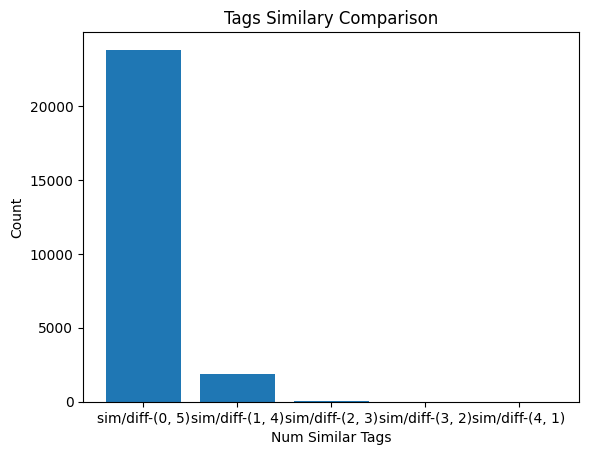

In [ ]:
plot_bins(bins_dict)

In [ ]:
NUM_COMPARISON_TAGS = 10
top_10_tags_tf_idf = get_top_tags_by(ROW_TF_IDF,num_tags=NUM_COMPARISON_TAGS)
top_10_tags_word2vec = get_top_tags_by(ROW_WORD2VEC,num_tags=NUM_COMPARISON_TAGS)

100%|██████████| 352/352 [01:23<00:00,  4.20it/s]

tags:  tf_idf | word2vec
0.  על | לצדק
1.  של | ישראל
2.  המשפט | פסק
3.  את | הישיבה
4.  כבוד | בע
5.  כי | ברק
6.  בית | המשיבים
7.  המערער | בת
8.  לא | צו
9.  עו"ד | ללא


In [ ]:
compare_top_tags(top_10_tags_tf_idf,"tf_idf",top_10_tags_word2vec,"word2vec",NUM_COMPARISON_TAGS)

tags:  tf_idf | word2vec
0.  על | לצדק
1.  של | ישראל
2.  המשפט | פסק
3.  את | הישיבה
4.  כבוד | בע
5.  כי | ברק
6.  בית | המשיבים
7.  המערער | בת
8.  לא | צו
9.  עו"ד | ללא


## 5. Dataset Statistics
    - In Certain TimeFrame:
    - a. Number of verdict of each judge
    - b. Number of verdicts each judge gave in the top 10 popular subject tags

In [ ]:
start_date = "2004-01-01"
end_date = "2005-01-01"

In [ ]:
def get_judge_names(first_names,last_names):
    first = first_names.strip('[ ]')
    first = first.replace("'", "")
    first = first.split(' ')
    last = last_names.strip('[ ]')
    last = last.replace("'", "")
    last = last.replace('"', "")
    last = last.split(' ')
    judge_names = [first[i] + " " + last[i] for i in range(len(first))]
    return judge_names


def get_date_from_string(dt):
    return datetime.datetime.strptime(dt,"%Y-%m-%d")

def is_in_date_range(start_date,end_date,date):
    start_date = get_date_from_string(start_date)
    end_date = get_date_from_string(end_date)
    date = get_date_from_string(date)
    if start_date <= date <= end_date:
        return True
    else:
        return False

In [ ]:
def get_stats_v1(start_date,end_date,top_10_tags,col_name):
    top_tags_counts = {tag:0 for tag in top_10_tags}
    judges_num_verdicts = { }
    for i,batch in tqdm(enumerate(batch_generator()),total=len(csv_files)):
        for index,row in batch.iterrows():
            text = row['text']
            verdict_date = row['meta_verdict_dt']
            first = row['meta_judge_nm_first']
            last = row['meta_judge_nm_last']
            tags = str_list_to_list(row[f'{col_name}_tags'])
            is_in_range = is_in_date_range(start_date,end_date,verdict_date)
            if not is_in_range:
                continue
            judge_names = get_judge_names(first,last)
            for judge in judge_names:
                if judge not in judges_num_verdicts.keys():
                    judges_num_verdicts[judge] = 0
                judges_num_verdicts[judge] += 1

            for tag in tags:
                if tag in top_tags_counts.keys():
                    top_tags_counts[tag] += 1
                    
    return top_tags_counts,judges_num_verdicts

def print_stats_v1(title,start_date,end_date,top_tags_counts,judges_num_verdicts):
    print(f"-- {title} --")
    print('start date: ',start_date, "end date: ", end_date)
    print("in this timeframe:")
    print()
    print("top 10 tags:")
    for tag,count in top_tags_counts.items():
        print(f"{tag}:",count)
    print()
    print("judges number of verdicts:")
    for judge,num_vertics in judges_num_verdicts.items():
        print(f"{judge}:",num_vertics)


In [ ]:
top_tags_counts1,judges_num_verdicts1 = get_stats_v1(start_date,end_date,top_10_tags_tf_idf,ROW_TF_IDF)

100%|██████████| 352/352 [01:14<00:00,  4.72it/s]


In [ ]:
print_stats_v1("tf_idf tags",start_date,end_date,top_tags_counts1,judges_num_verdicts1)

-- tf_idf tags --
start date:  2004-01-01 end date:  2005-01-01
in this timeframe:

top 10 tags:
על: 2287
של: 2226
המשפט: 1504
את: 1714
כבוד: 1359
כי: 1488
בית: 443
המערער: 612
לא: 424
עו"ד: 365

judges number of verdicts:
דורית ביניש: 721
אילה פרוקציה: 512
סלים גובראן: 515
אהרן ברק: 636
תאודור אור: 110
אליהו מצא: 462
אדמונד לוי: 637
אשר גרוניס: 667
מרים נאור: 760
עדנה ארבל: 112
מישאל חשין: 425
אליעזר ריבלין: 570
אליקים רובינשטיין: 129
דליה דורנר: 137
יעקב טירקל: 233
אסתר חיות: 562
חגית מאק-קלמנוביץ: 115
אילה
 פרוקציה
: 3
יהונתן עדיאל: 332
יגאל מרזל: 3
טובה שטרסברג-כהן: 1
עודד שחם: 5
בעז אוקון: 2
שלמה לוין: 1


In [ ]:
top_tags_counts2,judges_num_verdicts2 = get_stats_v1(start_date,end_date,top_10_tags_word2vec,ROW_WORD2VEC)

100%|██████████| 352/352 [01:29<00:00,  3.95it/s]


In [ ]:
print_stats_v1("word2vec tags",start_date,end_date,top_tags_counts2,judges_num_verdicts2)

-- word2vec tags --
start date:  2004-01-01 end date:  2005-01-01
in this timeframe:

top 10 tags:
לצדק: 1067
ישראל: 857
פסק: 747
הישיבה: 692
בע: 633
ברק: 615
המשיבים: 395
בת: 379
צו: 342
ללא: 388

judges number of verdicts:
דורית ביניש: 721
אילה פרוקציה: 512
סלים גובראן: 515
אהרן ברק: 636
תאודור אור: 110
אליהו מצא: 462
אדמונד לוי: 637
אשר גרוניס: 667
מרים נאור: 760
עדנה ארבל: 112
מישאל חשין: 425
אליעזר ריבלין: 570
אליקים רובינשטיין: 129
דליה דורנר: 137
יעקב טירקל: 233
אסתר חיות: 562
חגית מאק-קלמנוביץ: 115
אילה
 פרוקציה
: 3
יהונתן עדיאל: 332
יגאל מרזל: 3
טובה שטרסברג-כהן: 1
עודד שחם: 5
בעז אוקון: 2
שלמה לוין: 1


## 6. Use RNN to perform NER recognision for dataset generation(2)

In [28]:
my_idf_dict = get_idf_dict(data_gen,queries)
my_idf_dict

100%|██████████| 36/36 [00:12<00:00,  2.90it/s]


{'של': 143268,
 'כי': 98162,
 'על': 96816,
 'את': 89038,
 'לא': 45800,
 'בית': 36221,
 'המערער': 34541,
 'המשפט': 34374,
 'זה': 33403,
 'או': 25872,
 'גם': 24133,
 'זו': 21111,
 'הוא': 20374,
 'אשר': 20266,
 'אין': 19404,
 'בין': 19062,
 'הדין': 18798,
 'כך': 17641,
 'היא': 17254,
 'יש': 16226,
 'עם': 16081,
 'סעיף': 16039,
 'אם': 15941,
 'להלן': 15802,
 'לחוק': 15101,
 'זאת': 14972,
 'כל': 14919,
 'כן': 13799,
 'היה': 13269,
 'השופט': 12965,
 'פסקה': 12948,
 'ניתן': 12940,
 'המחוזי': 12582,
 'משפט': 12576,
 'ראו': 12368,
 'אף': 12140,
 'לאחר': 11576,
 'עניין': 11260,
 'ישראל': 10759,
 'המשיב': 10306,
 'באופן': 10170,
 'כדי': 10077,
 'ידי': 9976,
 'שלא': 9394,
 'בו': 9148,
 'בעניין': 9021,
 'לפי': 8915,
 'אינו': 8583,
 'לו': 8582,
 'כאמור': 8520,
 'ביחס': 8439,
 'אינה': 8401,
 'אלה': 8222,
 'לכך': 8157,
 'במסגרת': 8138,
 'כאשר': 8016,
 'כפי': 7973,
 'מדובר': 7846,
 'עוד': 7809,
 'ביום': 7776,
 'אלא': 7773,
 'ולא': 7624,
 'דין': 7494,
 'מקום': 7239,
 'הצדדים': 7138,
 'דינו': 7114,
 'פסק

In [29]:
def make_tag_lookup_table(ner_labels):
    iob_labels = ["B", "I"]
    all_labels = [(label1, label2) for label2 in ner_labels for label1 in iob_labels]
    all_labels = ["-".join([a, b]) for a, b in all_labels]
    all_labels = ["<PAD>", "O","<NEXT>"] + all_labels
    return dict(zip(range(0, len(all_labels) + 1), all_labels))

In [30]:

NER_LAWYER = "LAWYER"
NER_JUDGE = "JUDGE"
NER_CASE = "CASE" 
NER_PROCEDURE = "PROCEDURE"
NER_DEFENSE_TITLE = "DEFENSE_TITLE"
NER_DEFENSE_PARTY = "DEFENSE_PARTY"
NER_DEFENSE_LAWYER = "DEFENSE_LAWYER"
NER_PROSECUTION_TITLE = "PROSECUTION_TITLE"
NER_PROSECUTION_PARTY = "PROSECUTION_PARTY"
NER_PROSECUTION_LAWYER = "PROSECUTION_LAWYER"
NER_VERDICT_DATE = "DATE"
NER_OTHER = "O"

my_ner_labels = [
        NER_LAWYER,
        NER_JUDGE,
        NER_CASE,
        NER_PROCEDURE,
        NER_DEFENSE_TITLE,
        NER_DEFENSE_PARTY,
        NER_DEFENSE_LAWYER,
        NER_PROSECUTION_TITLE,
        NER_PROSECUTION_PARTY,
        NER_PROSECUTION_LAWYER,
        NER_VERDICT_DATE,
    ]

ner_mapping = make_tag_lookup_table(my_ner_labels)
keys = list(ner_mapping.keys())
values = list(ner_mapping.values())
reverse_ner_mapping = {values[i]:keys[i] for i in range(len(keys))}
print(ner_mapping)
print(reverse_ner_mapping)


MAX_WORDS = 20000
vocab = list(set(list(my_idf_dict.keys())))[:MAX_WORDS - 2]
vocab.append("unknown") 
vocab_idx2token = {idx:tok for  idx, tok in enumerate(vocab)}
vocab_token2idx = {tok:idx for  idx, tok in enumerate(vocab)}

len(vocab)



{0: '<PAD>', 1: 'O', 2: '<NEXT>', 3: 'B-LAWYER', 4: 'I-LAWYER', 5: 'B-JUDGE', 6: 'I-JUDGE', 7: 'B-CASE', 8: 'I-CASE', 9: 'B-PROCEDURE', 10: 'I-PROCEDURE', 11: 'B-DEFENSE_TITLE', 12: 'I-DEFENSE_TITLE', 13: 'B-DEFENSE_PARTY', 14: 'I-DEFENSE_PARTY', 15: 'B-DEFENSE_LAWYER', 16: 'I-DEFENSE_LAWYER', 17: 'B-PROSECUTION_TITLE', 18: 'I-PROSECUTION_TITLE', 19: 'B-PROSECUTION_PARTY', 20: 'I-PROSECUTION_PARTY', 21: 'B-PROSECUTION_LAWYER', 22: 'I-PROSECUTION_LAWYER', 23: 'B-DATE', 24: 'I-DATE'}
{'<PAD>': 0, 'O': 1, '<NEXT>': 2, 'B-LAWYER': 3, 'I-LAWYER': 4, 'B-JUDGE': 5, 'I-JUDGE': 6, 'B-CASE': 7, 'I-CASE': 8, 'B-PROCEDURE': 9, 'I-PROCEDURE': 10, 'B-DEFENSE_TITLE': 11, 'I-DEFENSE_TITLE': 12, 'B-DEFENSE_PARTY': 13, 'I-DEFENSE_PARTY': 14, 'B-DEFENSE_LAWYER': 15, 'I-DEFENSE_LAWYER': 16, 'B-PROSECUTION_TITLE': 17, 'I-PROSECUTION_TITLE': 18, 'B-PROSECUTION_PARTY': 19, 'I-PROSECUTION_PARTY': 20, 'B-PROSECUTION_LAWYER': 21, 'I-PROSECUTION_LAWYER': 22, 'B-DATE': 23, 'I-DATE': 24}


19999

In [31]:
def string_to_list(lst_str:str):
    return lst_str.split("|")

def string_to_nested_list(lst_str:str):
    lst = []
    for item in lst_str.split("@"):
        lst.append(string_to_list(item))
    return lst


def get_raw_bag_of_words(text:str):
    t = remove_extra_spaces(text).strip()
    words = t.split(" ")
    words = [word.strip() for word in words if len(word.strip()) > 0]
    return words


def split_and_pad_string(input_string, chunk_size, padding_character):
    chunks = [input_string[i:i+chunk_size] for i in range(0, len(input_string), chunk_size)]
    last_chunk_length = len(chunks[-1])
    if padding_character:
        if last_chunk_length < chunk_size:
            chunks[-1] = chunks[-1].ljust(chunk_size, padding_character)
    return chunks


def get_sentences(text,size,split_string=".", padding_character=" "):
    bag = get_raw_bag_of_words(text)
    text = ' '.join(bag)
    sentences = text.split(split_string)
    sentences = [s.strip() for s in sentences if len(s.strip()) > 1]
    sentences = [s.strip()[:len(s)- 1].strip() if s[len(s) - 1].isdigit() else s for s in sentences]
    sentences = [s.strip() for s in sentences if len(s.strip()) > size]
    sentences = [split_and_pad_string(s,size,padding_character) for s in sentences]

    combined_list_sentences = []
    for sen in sentences:
        combined_list_sentences.extend(sen)
    return combined_list_sentences
    

def replace_pattern_to_ner_label(text,ner_label,multi_word_expression:str):
    expression = multi_word_expression
    new_text = text
    label_text = " "
    num_words_in_expression = len(expression.split(" "))
    for word in range(num_words_in_expression):
        label_text += ner_label + " "
    label_text = label_text.strip()
    pattern = re.compile(r"\b" + re.escape(expression) + r"\b")
    modified_text = re.sub(pattern,label_text,new_text)
    if modified_text != text:
        return modified_text  
    print("not changed")      
    return new_text


def replace_patterns_to_ner_label(text,ner_label,expressions):
    new_text = text
    if isinstance(expressions,list):
        for expressions in expressions:
            new_text = replace_pattern_to_ner_label(new_text,ner_label,expressions)
        return new_text
    if isinstance(expressions,str):
        new_text =  replace_pattern_to_ner_label(new_text,ner_label,expressions)
        return new_text
    return new_text




In [32]:
def get_judges_names(row): # done 
    honor_prefix = "כבוד"
    female_judge_prefix =  " " +  "השופטת"
    male_judge_prefix = " " +  "השופט"
    first_names = row['judge_first_names']
    last_names = row['judge_last_names']
    judge_genders = row['judges_genders']
    last = string_to_list(last_names)
    first = string_to_list(first_names)
    genders = string_to_list(judge_genders)
    judges = [last[i] +"' "+ first[i] for i in range(len(first))]    
    judges_with_genders_prefixes = None
    judges_with_genders_prefixes_and_honor_prefixes = None
    for i in range(len(first)):
        if genders[i] == "male":
            judges_with_genders_prefixes = [last[i] +"' "+ first[i] + male_judge_prefix for i in range(len(first))]    
            judges_with_genders_prefixes_and_honor_prefixes = [j  +  " "  +  honor_prefix for j in judges_with_genders_prefixes] 
        if genders[i] == "female":
            judges_with_genders_prefixes = [last[i] +"' "+ first[i] + female_judge_prefix for i in range(len(first))]    
            judges_with_genders_prefixes_and_honor_prefixes = [j  +  " "  +  honor_prefix for j in judges_with_genders_prefixes] 
    return judges,judges_with_genders_prefixes, judges_with_genders_prefixes_and_honor_prefixes

    

def get_team_one_names(row):
    team_one_names = row['team_one_names']
    team_one_names = string_to_list(team_one_names)
    team_one_names = [remove_extra_spaces_without_lines(p) for p in team_one_names]
    team_one_names = [t for t in team_one_names if len(t.strip()) > 0]
    return team_one_names

def get_team_two_names(row):
    team_two_names = row['team_two_names']
    team_two_names = string_to_list(team_two_names)
    team_two_names = [remove_extra_spaces_without_lines(p) for p in team_two_names]
    team_two_names = [t for t in team_two_names if len(t.strip()) > 0]
    return team_two_names

def get_team_one_parties(row):
    parties = row['team_one']
    parties = string_to_nested_list(parties)
    team_one_parties = []
    for party in parties:
        team_one_parties = [remove_extra_spaces_without_lines(p) for p in party]
    team_one_parties = [t for t in team_one_parties if len(t.strip()) > 0]
    return team_one_parties

def get_team_two_parties(row):
    parties = row['team_two']
    parties = string_to_nested_list(parties)
    team_two_parties = []
    for party in parties:
        team_two_parties = [remove_extra_spaces_without_lines(p) for p in party]    
    team_two_parties = [t for t in team_two_parties if len(t.strip()) > 0]
    return team_two_parties


def get_team_one_lawyers_teams_names(row):
    teams = row['team_one_lawyers_teams_names']
    teams = string_to_list(teams)
    teams = [remove_extra_spaces_without_lines(p) for p in teams]
    teams = [t for t in teams if len(t.strip()) > 0]
    return teams


def get_team_one_lawyers(row):
    lawyers = row['team_one_lawyers']
    lawyers = string_to_nested_list(lawyers)
    lawyers_parties = []
    for party in lawyers:
        lawyers_parties = [remove_extra_spaces_without_lines(p) for p in party]    
    lawyers_parties = [t for t in lawyers_parties if len(t.strip()) > 0]
    return lawyers_parties

def get_team_two_lawyers_teams_names(row):
    teams = row['team_two_lawyers_teams_names']
    teams = string_to_list(teams)
    teams = [remove_extra_spaces_without_lines(p) for p in teams]
    teams = [t for t in teams if len(t.strip()) > 0]
    return teams    

def get_team_two_lawyers(row):
    lawyers = row['team_two_lawyers']
    lawyers = string_to_nested_list(lawyers)
    lawyers_parties = []
    for party in lawyers:
        lawyers_parties = [remove_extra_spaces_without_lines(p) for p in party]    
    lawyers_parties = [t for t in lawyers_parties if len(t.strip()) > 0]
    return lawyers_parties   

def get_all_lawyers_teams_names(row):
    lawyers_teams = row['all_lawyers_teams_names']
    lawyers_teams = string_to_list(lawyers_teams)
    lawyers_teams = [remove_extra_spaces_without_lines(p) for p in lawyers_teams]
    lawyers_teams = [t for t in lawyers_teams if len(t.strip()) > 0]
    return lawyers_teams


def get_all_lawyers(row):
    lawyer_prefix ='ע"וד'
    all_lawyers = row['all_lawyers']
    all_lawyers = string_to_nested_list(all_lawyers)
    lawyers_parties = []
    for party in all_lawyers:
        lawyers_parties = [remove_extra_spaces_without_lines(p) for p in party]    
    lawyers_parties = [t for t in lawyers_parties if len(t.strip()) > 0]
    return lawyers_parties


def get_procedures(row):
    procedures = row["procedures"]
    procedures = string_to_list(procedures)
    procedures = [remove_extra_spaces_without_lines(p) for p in procedures]
    return procedures

def get_date(row):
    date = row['date']
    date = date.strip()
    return date


def get_title(row):
    title = row['title']
    title = title.strip()
    title = remove_extra_spaces(title)
    return title



In [33]:
def _words_to_ner_label(words,ner_label):
    tokens = words.split(" ")
    ners = []
    for i,token in enumerate(tokens):
        if i == 0:
            ners.append("B-" + ner_label)
        else:
            ners.append("I-" + ner_label)
    return ners

def words_to_ner_label(words,ner_label):
    lst = []
    if isinstance(words,list):
        for l in lst:
            ner_lst = _words_to_ner_label(l,ner_label)
            ner_text = " ".join(ner_lst)
            lst.append(ner_text) 
            ner_text = " ".join(lst)
            return ner_text
    if isinstance(words,str):
        lst = _words_to_ner_label(words,ner_label)
        ner_text = " ".join(lst)
        return ner_text
    return None


In [34]:
def get_sentences_max_size(word_list, ner_labels,end_sentences=('.', '!', '?')):
    sentence_tokens = []
    label_tokens = []

    current_sentence = []
    current_labels = []
    best_sentences_size = -1

    last = None
    for word, label in zip(word_list, ner_labels):
        if label.startswith("B-"):
            last = label[2:]
        else:
            if last and label == "I-" + last:
                current_sentence.append(word)
                current_labels.append(label)
                continue
            else:
                last = None

        current_sentence.append(word)
        current_labels.append(label)

        if best_sentences_size < len(current_sentence):
            best_sentences_size = len(current_sentence)
            
        if word.endswith(end_sentences):
            sentence_tokens.append(current_sentence)
            label_tokens.append(current_labels)
            current_sentence = []
            current_labels = []          
        


    return best_sentences_size

def create_sentences_with_padding(word_list, ner_labels, max_sentence_size,end_sentences=('.', '!', '?'),padding_value=['<PAD>'],next_label="<NEXT>"):
    sentence_tokens = []
    label_tokens = []

    current_sentence = []
    current_labels = []

    last = None
    for word, label in zip(word_list, ner_labels):
        if label.startswith("B-"):
            last = label[2:]
        else:
            if last and label == "I-" + last:
                current_sentence.append(word)
                current_labels.append(label)
                continue
            else:
                last = None

        current_sentence.append(word)
        current_labels.append(label)

        if word.endswith(end_sentences):
            if len(current_sentence) >= max_sentence_size:
                sentence_tokens.append(current_sentence)
                label_tokens.append(current_labels)
                current_sentence = []
                current_labels = []
                continue

        if len(current_sentence) >= max_sentence_size:
            current_labels = current_labels[:len(current_labels) - 1]
            current_sentence = current_sentence[:len(current_sentence) - 1]
            current_sentence.append(next_label)
            current_labels.append(next_label)
            sentence_tokens.append(current_sentence)
            label_tokens.append(current_labels)
            current_sentence = [word]
            current_labels = [label]
            continue


        
    if current_sentence:
        sentence_tokens.append(current_sentence)
        label_tokens.append(current_labels)

    padded_sentence_tokens = []
    padded_label_tokens = []

    for sentence, labels in zip(sentence_tokens, label_tokens):
        padding_length = max_sentence_size - len(sentence)
        padded_sentence = sentence + padding_value * padding_length
        padded_labels = labels + padding_value * padding_length
        padded_sentence_tokens.append(padded_sentence)
        padded_label_tokens.append(padded_labels)

    return padded_sentence_tokens, padded_label_tokens



In [35]:
def is_in_text(items,text):
    all_in_text = True
    if isinstance(items,list):
        for j in items:
            jj = j
            if isinstance(jj,list):
                for item in jj:
                    if item in text:
                        print("in text:",item)
                    else:
                        print("not in text:",item)
                        all_in_text = False
            else:
                if jj in text:
                    print("in text:",jj)
                else:
                    print("not in text:",jj)
                    all_in_text = False
    else:
        if items in text:
            print("in text:",items)
        else:
            print("not in text:",items)
            all_in_text = False
    return all_in_text



def _replace_expression_with_ner_label(text:str,expression:str,ner_label:str):
    ners = words_to_ner_label(expression,ner_label)
    if not ners:
        return text
    modified_text = text.replace(expression,ners)
    return modified_text

def replace_expression_with_ner_label(text:str,expressions:typing.Union[str,list,None],ner_label:str):
    new_text = text
    if expressions is None:
        return new_text
    if isinstance(expressions,list):
        for expression in expressions:
            new_text = _replace_expression_with_ner_label(new_text,expression,ner_label)

    if isinstance(expressions,str):
        new_text = _replace_expression_with_ner_label(new_text,expressions,ner_label)
    return new_text
    
    


def replace_ners(row,text):
    date = get_date(row)
    title = get_title(row)
    proz = get_procedures(row)
    judges , judges_with_gender_prefix , judges_with_gender_honor_prefix = get_judges_names(row)
    lawyers = get_all_lawyers(row)

    text_tokens = text.split(" ")

    ner_text = text
    ner_text = replace_expression_with_ner_label(ner_text,date,NER_VERDICT_DATE)
    ner_text = replace_expression_with_ner_label(ner_text,title,NER_CASE)
    ner_text = replace_expression_with_ner_label(ner_text,proz,NER_PROCEDURE)
    ner_text = replace_expression_with_ner_label(ner_text,judges_with_gender_honor_prefix,NER_JUDGE)
    ner_text = replace_expression_with_ner_label(ner_text,judges_with_gender_prefix,NER_JUDGE)
    ner_text = replace_expression_with_ner_label(ner_text,judges,NER_JUDGE)
    ner_text = replace_expression_with_ner_label(ner_text,lawyers,NER_LAWYER)


    tokens = ner_text.split(" ")
    ner_tokens = []
    for token in tokens:
        if token in list(ner_mapping.values()):
            ner_tokens.append(token)
        else:
            ner_tokens.append(NER_OTHER)
    
    if len(text_tokens) != len(ner_tokens):
        raise Exception()

    return text_tokens,ner_tokens


def encode_ner_tags(batch_ner_tags):
    new_tags = []
    for ner_tags in batch_ner_tags:
        new_tags.append([reverse_ner_mapping[tag] for tag in ner_tags])
    return new_tags


def encode_sentences(vocab, tokens):
    keys = list(vocab.keys())
    return [vocab[token] if token in keys else len(keys) - 1 for token in tokens]
            


def create_sentences_tokens_ners_labels_batch(row,max_len_sentences):
    verdict_data_divider = "דין-פסק"
    text = row['text']
    
    meta_text = text.split(verdict_data_divider)[0]
    verdict_text = text.split(verdict_data_divider)[1]    

    meta_text_tokens,meta_ner_tokens = replace_ners(row,meta_text) 
    data_text_tokens,data_ner_tokens = replace_ners(row,verdict_text) 

    m1 = get_sentences_max_size(meta_text_tokens,meta_ner_tokens,end_sentences=("\n"," "))
    m2 = get_sentences_max_size(data_text_tokens,data_ner_tokens,end_sentences=('.','!','?'))


    sen1 , lab1 = create_sentences_with_padding(meta_text_tokens,meta_ner_tokens,max_len_sentences,end_sentences=("\n"," "))
    sen2 , lab2 = create_sentences_with_padding(data_text_tokens,data_ner_tokens,max_len_sentences,end_sentences=('.','!','?'))

    sentences = sen1 + sen2
    ners_tags = lab1 + lab2
    
    return sentences , ners_tags
    

        


In [36]:
vocab_token2idx

{'תחייבנה': 0,
 'עבר-חלף': 1,
 'לבוחנן': 2,
 '300-ו': 3,
 'יתלה': 4,
 'לוינר': 5,
 'אמצעי-בלתי': 6,
 'על10': 7,
 'ובסיוע': 8,
 'יודגש"': 9,
 'מהאופן"': 10,
 'המורישים': 11,
 'להעצמתם': 12,
 'צדקה': 13,
 'וכמי': 14,
 'בהתנדבות': 15,
 'נפגעת': 16,
 'קפוטה': 17,
 'יתרון92': 18,
 'שהתיקונים': 19,
 'מפוקחות': 20,
 'שמופקדת': 21,
 'עושרם': 22,
 'שהסרטון': 23,
 "פלנטה'ב": 24,
 'להשתתף–': 25,
 'מבור': 26,
 'פוסלת': 27,
 'שנתייםוכ': 28,
 'שהתמלאו': 29,
 'בפסיקה6': 30,
 'שהקשר': 31,
 'פ"בבש': 32,
 'משמעשהו': 33,
 'דקלים': 34,
 'התשואות': 35,
 '1414-ל': 36,
 'מותירות': 37,
 'או9': 38,
 'דיוקו': 39,
 'מסקנותיו': 40,
 'הפלורליסטיים': 41,
 'להידבק': 42,
 'שנעלם': 43,
 'דירה-"ל': 44,
 'הדרכת': 45,
 'חילוט-כברי': 46,
 'ומופנה': 47,
 'בכפוף18': 48,
 'הנוסעים': 49,
 'הביקורת"': 50,
 'יחמוק': 51,
 '"הצבת': 52,
 'והזוכה': 53,
 'מישהו3': 54,
 'לשפיטתו': 55,
 'פני6': 56,
 'משען': 57,
 'להתקדמותו': 58,
 'לצוואות': 59,
 'וכחודש': 60,
 "שציינה'": 61,
 '"הירושה': 62,
 'יתנקם': 63,
 '"שומעין': 64,
 'קִצו': 65,
 

In [37]:
vocabulary = list(vocab_token2idx.keys())

In [38]:
def get_token_idx(token):
    if token in vocabulary:
        return vocab_token2idx[token]
    return len(vocabulary) - 1

def get_word_from_idx(idx):
    if idx > 0 and idx < len(vocabulary) - 1:
        return vocab_idx2token[idx]
    return vocab_idx2token[len(vocabulary) - 1]

def get_words_from_encoded_sentence(indexes):
    words = []
    for index in indexes:
        words.append(get_word_from_idx(index))
    return words

def get_indexes_from_words(tokens):
    indexes = []
    for token in tokens:
        index = get_token_idx(token)
        indexes.append(index)
    return indexes

def get_ner_idx(ner):
    return reverse_ner_mapping[ner]

def get_indexes_from_ners(ners):
    indexes = []
    for ner in ners:
        index = get_ner_idx(ner)
        indexes.append(index)
    return indexes



In [54]:

for idx,batch in tqdm(enumerate(data_gen()),total=len(queries)):
    batch = batch[batch['text'].notna()]
    for index,row in batch.iterrows():
        text = row['text']
        tokens = get_raw_bag_of_words(text)
        token = tokens[0:10]
        i =get_indexes_from_words(token)
        w = get_words_from_encoded_sentence(i)
        print(i,w)
        break
    break




  0%|          | 0/36 [00:00<?, ?it/s]

[19998, 19998, 5903, 19998, 19998, 19998, 19998, 19998, 19998, 19998] ['unknown', 'unknown', 'בבית', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']


In [39]:
train_data_dict = {"tokens":[], "ner_tags":[]}
validation_data_dict = {"tokens":[], "ner_tags":[]}
MAX_SEN_LENGTH = 25

for idx,batch in tqdm(enumerate(data_gen()),total=len(queries)):
    batch = batch[batch['text'].notna()]
    for index,row in batch.iterrows():
        text = row['text']
        try:
            sentences , ners_tags = create_sentences_tokens_ners_labels_batch(row,MAX_SEN_LENGTH)
            split_index = int(len(sentences) * 0.8)

            train_sentences = sentences[:split_index]
            train_ner_tags = ners_tags[:split_index]

            val_sentences = sentences[split_index:]
            val_ner_tags = ners_tags[split_index:]


            train_data_dict['tokens'].extend(train_sentences)
            train_data_dict['ner_tags'].extend(train_ner_tags)

            validation_data_dict['tokens'].extend(val_sentences)
            validation_data_dict['ner_tags'].extend(val_ner_tags)

        except Exception as e:
            continue


100%|██████████| 36/36 [00:08<00:00,  4.10it/s]


In [40]:
train_df = pd.DataFrame(data=train_data_dict)
val_df = pd.DataFrame(data=validation_data_dict)

In [41]:
len(train_df)

197462

In [42]:
sub_train_df = train_df[:8000]
sub_val_df = train_df[:2000]


In [43]:
sub_train_df['tokens'] = sub_train_df['tokens'].apply(lambda tokens: get_indexes_from_words(tokens))
sub_val_df['tokens'] = sub_val_df['tokens'].apply(lambda tokens: get_indexes_from_words(tokens))

/tmp/ipykernel_464637/3394779955.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_train_df['tokens'] = sub_train_df['tokens'].apply(lambda tokens: get_indexes_from_words(tokens))
/tmp/ipykernel_464637/3394779955.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_val_df['tokens'] = sub_val_df['tokens'].apply(lambda tokens: get_indexes_from_words(tokens))


In [44]:
sub_train_df['ner_tags'] = sub_train_df['ner_tags'].apply(lambda tokens: get_indexes_from_ners(tokens))
sub_val_df['ner_tags'] = sub_val_df['ner_tags'].apply(lambda tokens: get_indexes_from_ners(tokens))

/tmp/ipykernel_464637/4050277662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_train_df['ner_tags'] = sub_train_df['ner_tags'].apply(lambda tokens: get_indexes_from_ners(tokens))
/tmp/ipykernel_464637/4050277662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_val_df['ner_tags'] = sub_val_df['ner_tags'].apply(lambda tokens: get_indexes_from_ners(tokens))


In [45]:
sub_train_df.head()

,tokens,ner_tags
0,"[19998, 5923, 19998, 19998, 19998, 19998, 1999...","[1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[5923, 10430, 19998, 19998, 19998, 19998, 1999...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[19998, 19998, 19998, 18736, 19998, 19998, 199...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 0, ..."
3,"[19998, 19998, 19998, 19998, 16807, 3768, 5923...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[19998, 19998, 19998, 11107, 19998, 19998, 199...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [47]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [48]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings


In [49]:
class NERModel(keras.Model):
    def __init__(
        self, num_tags, vocab_size, maxlen=128, embed_dim=32, num_heads=2, ff_dim=32
    ):
        super().__init__()
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.dropout1 = layers.Dropout(0.1)
        self.ff = layers.Dense(ff_dim, activation="relu")
        self.dropout2 = layers.Dropout(0.1)
        self.ff_final = layers.Dense(num_tags, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.transformer_block(x)
        x = self.dropout1(x, training=training)
        x = self.ff(x)
        x = self.dropout2(x, training=training)
        x = self.ff_final(x)
        return x

In [50]:

class CustomNonPaddingTokenLoss(keras.losses.Loss):
    def __init__(self, name="custom_ner_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction=keras.losses.Reduction.NONE
        )
        loss = loss_fn(y_true, y_pred)
        mask = tf.cast((y_true > 0), dtype=tf.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)
    


In [76]:
num_tags = len(list(ner_mapping.keys()))
vocab_size = len(vocabulary)
batch_size = 32
epoch = 10
embedding_dim = 100
hidden_units = 64
sequence_length = -1

In [82]:
train_input_data = sub_train_df['tokens'].values
train_output_data = sub_train_df['ner_tags'].values
max_sequence_length = max(len(seq) for seq in train_input_data)

if sequence_length <  max_sequence_length:
    sequence_length = max_sequence_length

padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_input_data, maxlen=max_sequence_length, padding='post')
train_input_data_tensor = tf.convert_to_tensor(padded_sequences, dtype=tf.int32)
max_sequence_length = max(len(seq) for seq in train_output_data)

if sequence_length <  max_sequence_length:
    sequence_length = max_sequence_length
    
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_output_data, maxlen=max_sequence_length, padding='post')
train_output_data_tensor = tf.convert_to_tensor(padded_sequences, dtype=tf.int32)
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_data_tensor, train_output_data_tensor))
train_dataset = train_dataset.padded_batch(batch_size)

In [83]:
val_input_data = sub_val_df['tokens'].values
val_output_data = sub_val_df['ner_tags'].values
max_sequence_length = max(len(seq) for seq in val_input_data)
if sequence_length <  max_sequence_length:
    sequence_length = max_sequence_length
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(val_input_data, maxlen=max_sequence_length, padding='post')
val_input_data_tensor = tf.convert_to_tensor(padded_sequences, dtype=tf.int32)

max_sequence_length = max(len(seq) for seq in val_output_data)
if sequence_length <  max_sequence_length:
    sequence_length = max_sequence_length
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(val_output_data, maxlen=max_sequence_length, padding='post')



val_output_data_tensor = tf.convert_to_tensor(padded_sequences, dtype=tf.int32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_input_data_tensor, val_output_data_tensor))
val_dataset = val_dataset.padded_batch(batch_size)

In [84]:
print(num_tags,vocab_size,sequence_length)

25 19999 27


In [68]:
ner_model = NERModel(num_tags,vocab_size, embed_dim=embedding_dim, num_heads=4, ff_dim=hidden_units)

In [69]:
def create_rnn_model(vocab_size, embedding_dim, hidden_units, num_classes):
    model = tf.keras.Sequential([
        layers.Embedding(vocab_size, embedding_dim),
        layers.LSTM(hidden_units, return_sequences=True),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

rnn_model = create_rnn_model(vocab_size,embedding_dim,hidden_units,num_tags) 
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


2023-07-14 13:17:52.029668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-14 13:17:52.030875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-14 13:17:52.031742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [85]:
def create_autoencoder_model(vocab_size, embedding_dim, hidden_units, sequence_length):
    input_layer = layers.Input(shape=(sequence_length,))
    embedding_layer = layers.Embedding(vocab_size, embedding_dim)(input_layer)
    encoder = layers.LSTM(hidden_units)(embedding_layer)
    decoder = layers.RepeatVector(sequence_length)(encoder)
    decoder = layers.LSTM(hidden_units, return_sequences=True)(decoder)
    output_layer = layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))(decoder)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    
    return model

autoencoder_model = create_autoencoder_model(vocab_size,embedding_dim,hidden_units,sequence_length)
autoencoder_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')


2023-07-14 13:23:02.272526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-14 13:23:02.273610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-14 13:23:02.274420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

## RNN Model

In [71]:
rnn_model.fit(train_dataset, epochs=epoch, batch_size=batch_size)

Epoch 1/10


2023-07-14 13:18:10.718934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [8000,27]
	 [[{{node Placeholder/_0}}]]
2023-07-14 13:18:10.719287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [8000,27]
	 [[{{node Placeholder/_1}}]]
2023-07-14 13:18:10.857492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

250/250 [==============================] - 5s 14ms/step - loss: 0.5015 - accuracy: 0.9273
Epoch 2/10
250/250 [==============================] - 4s 15ms/step - loss: 0.1222 - accuracy: 0.9622
Epoch 3/10
250/250 [==============================] - 4s 15ms/step - loss: 0.1038 - accuracy: 0.9647
Epoch 4/10
250/250 [==============================] - 4s 15ms/step - loss: 0.0819 - accuracy: 0.9769
Epoch 5/10
250/250 [==============================] - 4s 16ms/step - loss: 0.0834 - accuracy: 0.9748
Epoch 6/10
250/250 [==============================] - 4s 16ms/step - loss: 0.0700 - accuracy: 0.9808
Epoch 7/10
250/250 [==============================] - 4s 16ms/step - loss: 0.0695 - accuracy: 0.9808
Epoch 8/10
250/250 [==============================] - 4s 16ms/step - loss: 0.0683 - accuracy: 0.9797
Epoch 9/10
250/250 [==============================] - 4s 16ms/step - loss: 0.0655 - accuracy: 0.9822
Epoch 10/10
250/250 [==============================] - 4s 16ms/step - loss: 0.0630 - accuracy: 0.9835


## AutoEncoder Model

In [86]:
autoencoder_model.fit(train_dataset, epochs=epoch, batch_size=batch_size)

Epoch 1/10


2023-07-14 13:23:06.208245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [8000,27]
	 [[{{node Placeholder/_1}}]]
2023-07-14 13:23:06.208543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [8000,27]
	 [[{{node Placeholder/_1}}]]
2023-07-14 13:23:06.344885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_d

250/250 [==============================] - 48s 183ms/step - loss: 2.0024
Epoch 2/10
250/250 [==============================] - 48s 190ms/step - loss: 0.4527
Epoch 3/10
250/250 [==============================] - 48s 194ms/step - loss: 0.4444
Epoch 4/10
250/250 [==============================] - 50s 202ms/step - loss: 0.4427
Epoch 5/10
250/250 [==============================] - 48s 190ms/step - loss: 0.4420
Epoch 6/10
250/250 [==============================] - 48s 192ms/step - loss: 0.4415
Epoch 7/10
250/250 [==============================] - 48s 192ms/step - loss: 0.4411
Epoch 8/10
250/250 [==============================] - 49s 197ms/step - loss: 0.4408
Epoch 9/10
250/250 [==============================] - 48s 192ms/step - loss: 0.4406
Epoch 10/10
250/250 [==============================] - 48s 191ms/step - loss: 0.4404


## Transformer Model

In [146]:
loss = CustomNonPaddingTokenLoss()
ner_model.compile(optimizer="adam", loss=loss)
ner_model.fit(train_dataset, epochs=epoch)


Epoch 1/10


2023-07-14 01:06:02.385811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [8000,27]
	 [[{{node Placeholder/_1}}]]
2023-07-14 01:06:02.386041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [8000,27]
	 [[{{node Placeholder/_1}}]]
/home/yuval/.local/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


250/250 [==============================] - 3s 8ms/step - loss: 0.1032
Epoch 2/10
250/250 [==============================] - 2s 8ms/step - loss: 0.0225
Epoch 3/10
250/250 [==============================] - 2s 8ms/step - loss: 0.0218
Epoch 4/10
250/250 [==============================] - 2s 9ms/step - loss: 0.0215
Epoch 5/10
250/250 [==============================] - 2s 9ms/step - loss: 0.0205
Epoch 6/10
250/250 [==============================] - 2s 10ms/step - loss: 0.0185
Epoch 7/10
250/250 [==============================] - 3s 12ms/step - loss: 0.0177
Epoch 8/10
250/250 [==============================] - 3s 12ms/step - loss: 0.0169
Epoch 9/10
250/250 [==============================] - 3s 10ms/step - loss: 0.0161
Epoch 10/10
250/250 [==============================] - 2s 10ms/step - loss: 0.0154


## 7. Compare (2) and (6)

In [149]:
def get_preds(dataset):
    all_true_tag_ids, all_predicted_tag_ids = [], []

    for x, y in dataset:
        output = ner_model.predict(x)
        predictions = np.argmax(output, axis=-1)
        predictions = np.reshape(predictions, [-1])

        true_tag_ids = np.reshape(y, [-1])

        mask = (true_tag_ids > 0) & (predictions > 0)
        true_tag_ids = true_tag_ids[mask]
        predicted_tag_ids = predictions[mask]

        all_true_tag_ids.append(true_tag_ids)
        all_predicted_tag_ids.append(predicted_tag_ids)

    all_true_tag_ids = np.concatenate(all_true_tag_ids)
    all_predicted_tag_ids = np.concatenate(all_predicted_tag_ids)

    predicted_tags = [ner_mapping[tag] for tag in all_predicted_tag_ids]
    real_tags = [ner_mapping[tag] for tag in all_true_tag_ids]
    return real_tags,predicted_tags

real_tags,predicted_tags = get_preds(val_dataset)


1/1 [==============================] - 0s 19ms/step


In [155]:
positive = 0
negative = 0
for i in range(len(real_tags)):
    if real_tags[i] == predicted_tags[i]:
        positive += 1
    else:
        negative +=1

In [157]:
print("Num Of Correct Token NER Predictions : ", positive)
print("Num Of Wrong Token NER Predictions : ", negative)

Num Of Correct Token NER Predictions :  49775
Num Of Wrong Token NER Predictions :  103


## 8. Use RNN to peform sentiment analysis on each verdict,  add sentiment Column for dataset (POSITIVE NETURAL NEGETIVE)

In [89]:
sentiment_analysis = pipeline(
    "sentiment-analysis",
    model="avichr/heBERT_sentiment_analysis",
    tokenizer="avichr/heBERT_sentiment_analysis",
    return_all_scores = True
)

/home/yuval/.local/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:89: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  warnings.warn(


In [90]:
se_input_size = 512

In [88]:
def get_sentiment(text:str):
    positive_c = 20
    neutral_c = 10
    negative_c = 0.1
    rest = se_input_size - len(text) % se_input_size
    num_iterations = int(len(text) / se_input_size) - 1
    negative = 0
    positive = 0
    neutral = 0
    start = 0
    end = se_input_size + 1
    for i in range(num_iterations):
        pos,net,neg = get_sub_sentiment(text,start,end)
        start += se_input_size
        end += se_input_size
        negative += neg
        neutral += net
        positive += pos

    if rest > 0:
        pos,net,neg = get_sub_sentiment(text,len(text) - 1 - rest ,len(text) - 1)
        negative += neg
        neutral += net
        positive += pos

    negative = negative * negative_c / num_iterations
    positive = positive * positive_c / num_iterations
    neutral = neutral * neutral_c / num_iterations
    
    output = None
    if negative > positive and negative > neutral:
        output =  "NEGATIVE"
    if positive > negative and positive > neutral:
        output = "POSITIVE"
    if neutral > negative and neutral > positive:
        output = "NEUTRAL"

    print("OUTPUT:",output,"| positive:",positive,"| negative:",negative,"| neutral:",neutral)
    return output
    



    
def get_sub_sentiment(text:str,start,end):
    t = text[start:end]
    se = sentiment_analysis(t)
    pos = 0
    neg = 0
    net = 0    
    for score in se:
        if score['label'] == "positive":
            pos = score['score']
        if score['label'] == "negative":
            neg = score['score']
        if score['label'] == "neutral":
            net = score['score']

    return pos,net,neg




In [92]:
for idx,batch in tqdm(enumerate(data_gen()),total=len(queries)):
    batch = batch[batch['text'].notna()]
    for index,row in batch.iterrows():
        text = row['text']
        row['sentiment'] = get_sentiment(text)


  0%|          | 0/36 [00:00<?, ?it/s]

OUTPUT: NEUTRAL | positive: 0.1285815097666769 | negative: 0.08775837236687288 | neutral: 1.6144175741812268
OUTPUT: NEUTRAL | positive: 0.029250732663382618 | negative: 0.09616774313963287 | neutral: 0.41810522705328357
OUTPUT: NEUTRAL | positive: 0.07245724404070174 | negative: 0.0847925697428441 | neutral: 1.6458046722747837
OUTPUT: NEUTRAL | positive: 0.26931737055265864 | negative: 0.08991059120778706 | neutral: 1.4625173504507127
OUTPUT: NEUTRAL | positive: 0.07607056328686335 | negative: 0.07905551300093693 | neutral: 2.110176840247458
OUTPUT: NEUTRAL | positive: 0.09803263049910865 | negative: 0.09740595984206137 | neutral: 0.3294353143965487
OUTPUT: NEUTRAL | positive: 0.015704079719615124 | negative: 0.09929496742173335 | neutral: 0.221381326869411
OUTPUT: NEUTRAL | positive: 0.07262592645669688 | negative: 0.0935841753643347 | neutral: 0.9624123780278231
OUTPUT: NEUTRAL | positive: 0.18214774045382479 | negative: 0.09190427225686634 | neutral: 1.244814711558559
OUTPUT: NEUTR

  3%|▎         | 1/36 [04:53<2:51:20, 293.72s/it]

OUTPUT: NEUTRAL | positive: 0.010840320601025322 | negative: 0.09885795071584119 | neutral: 0.22643183370553957
OUTPUT: NEUTRAL | positive: 0.08268343102827203 | negative: 0.0900664607195982 | neutral: 1.6662978181245438
OUTPUT: NEUTRAL | positive: 0.09370064465085391 | negative: 0.07173344011900427 | neutral: 2.837945183454458
OUTPUT: NEUTRAL | positive: 0.07607056328686335 | negative: 0.07905551300093693 | neutral: 2.110176840247458


  3%|▎         | 1/36 [05:50<3:24:16, 350.20s/it]

OUTPUT: NEUTRAL | positive: 0.14908602357931872 | negative: 0.08101004180346576 | neutral: 2.0418441819271287


ZeroDivisionError: float division by zero

## 9. Dataset Statistics with extra stats:
    - number of verdicts each judge gave for every sentiment type
    - In Certain TimeFrame: num of verdicts all judges gave for every sentiment type  

In [ ]:
start_date = "2004-01-01"
end_date = "2005-01-01"


## 10. 2-5 subject tags for each verdict using AUTOENCODER  

In [ ]:
def create_autoencoder_model(vocab_size, embedding_dim, hidden_dim):
    input_layer = layers.Input(shape=(None,))
    embedding_layer = layers.Embedding(vocab_size, embedding_dim)(input_layer)
    encoder = layers.LSTM(hidden_dim)(embedding_layer)
    decoder = layers.RepeatVector(tf.shape(embedding_layer)[1])(encoder)
    decoder = layers.LSTM(hidden_dim, return_sequences=True)(decoder)
    output_layer = layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))(decoder)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [ ]:
vocab_size = 10000
embedding_dim = 100
hidden_dim = 64

# Create the autoencoder model
autoencoder_model = create_autoencoder_model(vocab_size, embedding_dim, hidden_dim)

# Compile the model
autoencoder_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Train the model on your text data
autoencoder_model.fit(train_data, train_data, epochs=10, batch_size=32)

# Encode the input text and decode the generated embedding
input_text = "Sample input text"
encoded_text = autoencoder_model.encoder.predict(input_text)
decoded_text = autoencoder_model.decoder.predict(encoded_text)

## - Compare (3), (4) , (10)